In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import plotly.express as px
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] = False
df = pd.read_csv("nyc_taxi.csv")
df.shape

(10320, 2)

In [3]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [5]:
df = df.set_index('timestamp').resample('H').mean().reset_index()
df.shape, df

((5160, 2),
                timestamp    value
 0    2014-07-01 00:00:00   9485.5
 1    2014-07-01 01:00:00   5433.0
 2    2014-07-01 02:00:00   3346.5
 3    2014-07-01 03:00:00   2216.5
 4    2014-07-01 04:00:00   2189.5
 ...                  ...      ...
 5155 2015-01-31 19:00:00  28288.5
 5156 2015-01-31 20:00:00  24138.0
 5157 2015-01-31 21:00:00  24194.5
 5158 2015-01-31 22:00:00  26515.0
 5159 2015-01-31 23:00:00  26439.5
 
 [5160 rows x 2 columns])

In [6]:
#express to plot entire data
fig = px.line(df.reset_index(), x='timestamp', y='value', title='NYC Taxi Demand')
#slider
fig.update_xaxes(
    rangeslider_visible = True,
    rangeselector = dict(
        buttons = list([
              dict(count=1, label='1y', step="year", stepmode="backward"),
              dict(count=2, label='2y', step="year", stepmode="backward"),
              dict(count=2, label='5y', step="year", stepmode="backward")
        ])
    )
)
fig.show()

In [7]:
from prophet import Prophet
taxi_df = df.reset_index()[['timestamp', 'value']].rename({'timestamp':'ds', 'value':'y'}, axis='columns')

In [8]:
#train test split
train = taxi_df[(taxi_df['ds'] >= '2014-07-01') & (taxi_df['ds'] <= '2015-01-27')]
test = taxi_df[(taxi_df['ds'] > '2015-01-27')]

In [9]:
m = Prophet(changepoint_range=0.95)
m.fit(train)

14:20:47 - cmdstanpy - INFO - Chain [1] start processing
14:20:47 - cmdstanpy - INFO - Chain [1] done processing


In [10]:
future = m.make_future_dataframe(periods=119, freq='H')

In [11]:
forecast = m.predict(future)
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
5155,2015-01-31 19:00:00,23782.305546,19230.639770,28673.494896
5156,2015-01-31 20:00:00,24346.333430,19314.852704,29069.362261
5157,2015-01-31 21:00:00,23223.036445,18357.984680,28366.924894
5158,2015-01-31 22:00:00,21031.090242,16388.121523,25786.629408
5159,2015-01-31 23:00:00,18503.945928,13975.794987,23077.689037


In [16]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2014-07-01 00:00:00,14680.598064,8884.015780,18268.709541,14680.598064,14680.598064,-1426.203293,-1426.203293,-1426.203293,-117.997792,-117.997792,-117.997792,-1308.205501,-1308.205501,-1308.205501,0.0,0.0,0.0,13254.394771
1,2014-07-01 01:00:00,14681.003153,5604.952165,15164.740091,14681.003153,14681.003153,-4434.927438,-4434.927438,-4434.927438,-3226.045631,-3226.045631,-3226.045631,-1208.881807,-1208.881807,-1208.881807,0.0,0.0,0.0,10246.075715
2,2014-07-01 02:00:00,14681.408242,2148.949666,11181.548108,14681.408242,14681.408242,-7998.779835,-7998.779835,-7998.779835,-6885.851257,-6885.851257,-6885.851257,-1112.928579,-1112.928579,-1112.928579,0.0,0.0,0.0,6682.628407
3,2014-07-01 03:00:00,14681.813331,-1226.130236,7872.187984,14681.813331,14681.813331,-11220.289880,-11220.289880,-11220.289880,-10199.366979,-10199.366979,-10199.366979,-1020.922901,-1020.922901,-1020.922901,0.0,0.0,0.0,3461.523451
4,2014-07-01 04:00:00,14682.218420,-2448.339580,6846.823909,14682.218420,14682.218420,-12651.417840,-12651.417840,-12651.417840,-11718.053089,-11718.053089,-11718.053089,-933.364751,-933.364751,-933.364751,0.0,0.0,0.0,2030.800580


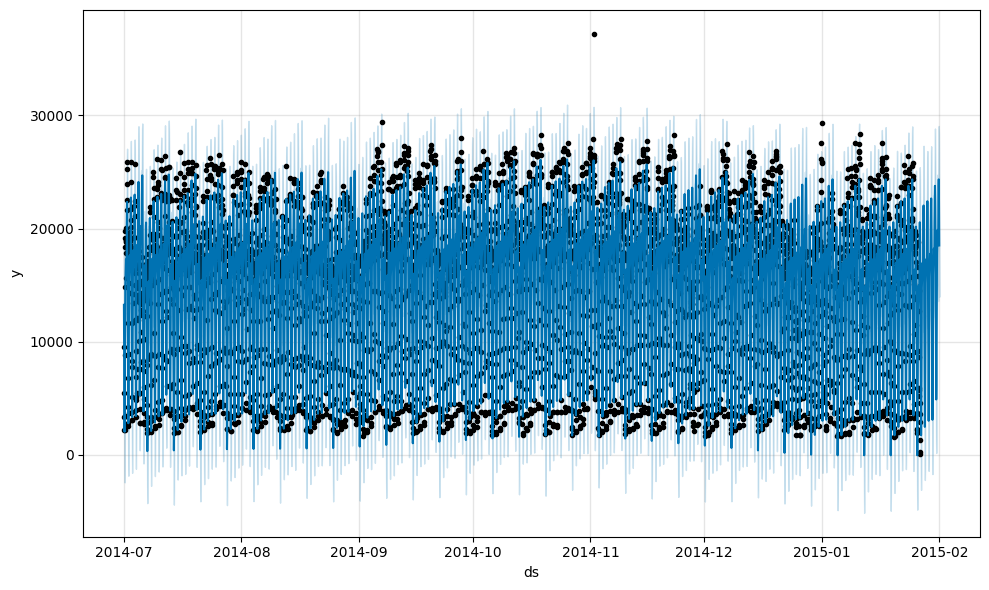

In [12]:
result = pd.concat([taxi_df.set_index('ds')['y'], forecast.set_index('ds')[['yhat','yhat_lower','yhat_upper']]], axis=1)
fig1 = m.plot(forecast)

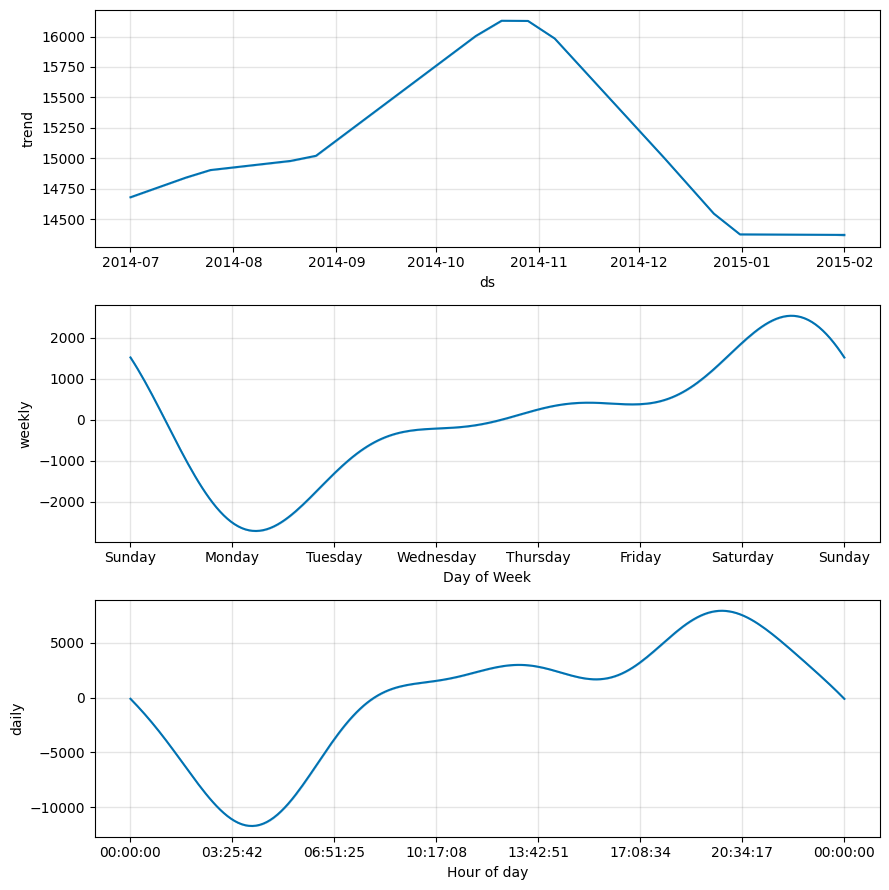

In [13]:
comp = m.plot_components(forecast)

In [17]:
result['error'] = result['y'] - result['yhat']
result['uncertainty'] = result['yhat_upper'] - result['yhat_lower']

In [19]:
result['anomaly'] = result.apply(lambda x: 'Yes' if(np.abs(x['error']) > 1.5*x['uncertainty']) else 'No', axis = 1)
#result['anomaly'] = np.where(np.abs(x['error']) > 1.5*x['uncertainty']), 'Yes', 'No') #Alternate way

In [21]:
fig = px.scatter(result.reset_index(), x='ds', y='y', color='anomaly', title='NYC Taxi Demand')
fig.show()